Define a rectangular grid covering the domain, with points
\begin{equation}
    (xi, yj ) = \left(\frac{i}{N_x}, \frac{j}{N_y}\right),
\end{equation}
for $0 \leq i \leq N_x$ and $0 \leq j \leq N_y$. The grid spacings are $\delta_x = 1/N_x$ and $\delta_y = 1/N_y$ in the $x$ and $y$ directions respectively. The variables $\zeta$ and $\psi$ are defined at each point on the grid and it is helpful to use the notation, $\psi_{i, j}^t = \psi(x_i, y_j, t)$ and $\zeta_{i, j}^t = \zeta(x_i, y_j , t)$. The superscripts denote the time at which a particular quantity is to be evaluated.

In order to integrate the Poisson equation in time it is sensible to use the $\zeta_{i, j}^t$ as the working independent variable and derive all the other quantities before  using finite-difference approximations for spatial derivatives. We use the expressions
\begin{equation}
    v_{i, j}^t = \frac{\psi_{i+1, j}^t - \psi_{i-1, j}^t}{2\delta_x}
\end{equation}
for $v$ and
\begin{equation}
    $J_{i, j}^t= \big[(\psi_{i+1, j+1} - \psi_{i-1, j+1}^t)\zeta_{i, j+1}^t - (\psi_{i+1, j-1}^t - \psi_{i-1, j-1}^t)\zeta_{i, j-1}^t - (\psi_{i+1, j+1}^t - \psi_{i+1, j-1}^t)\zeta_{i+1, j}^t + (\psi_{i-1, j+1}^t - \psi_{i-1, j-1}^t)\zeta_{i-1, j}^t\big] / 4\delta_x\delta_y,
\end{equation}
for the Jacobian, both evaluated at the point $(x_i, y_j)$ and time $t$. To begin, we integrate in time using the explicit Euler scheme in the form
\begin{equation}
    \zeta_{i, j}^{t+\Delta t} - \zeta_{i, j}^t + J_{i, j}^t\Delta t + v_{o, j}^t\Delta t = - \frac{1}{2}\epsilon(\zeta_{i, j}^{t+\Delta t} + \zeta_{i, j}^t)\Delta t + R\tau_{i,j}\Delta t
\end{equation}
for $1 \leq i \leq N_x - 1$ and $1 \leq j \leq N_y - 1$. Note that the boundary condition on $\psi$ means that evaluating $J_{i,j}$ via at points immediately adjacent to the boundary does not require knowledge of $\zeta$ on the boundary itself. There is no need to impose or determine $\zeta$ on the boundary at any stage.

Take $\tau = - \sin \pi x \sin \pi y$. The numerical accuracy of the time integration is not particularly important here because it is only the final steady state that is of interest. We need to find a time step $\Delta t$ small enough so that the integration remains stable and approaches a steady state but large enough to not incur computational inefficiencies.

We focus first on the case where $R$ is very small. In this regime we assume that $\zeta$ and $\psi$ scale with $R$ and so it is helpful to redefine them as $\hat\zeta = \zeta/R$ and $\hat\psi = \psi/R$. Then in the limit $R \to 0$ the nonlinear term involving the Jacobian may be neglected, and the steady state form can be approximated as
\begin{equation}
    \hat{v} = -\epsilon\hat\zeta + \tau.
\end{equation}

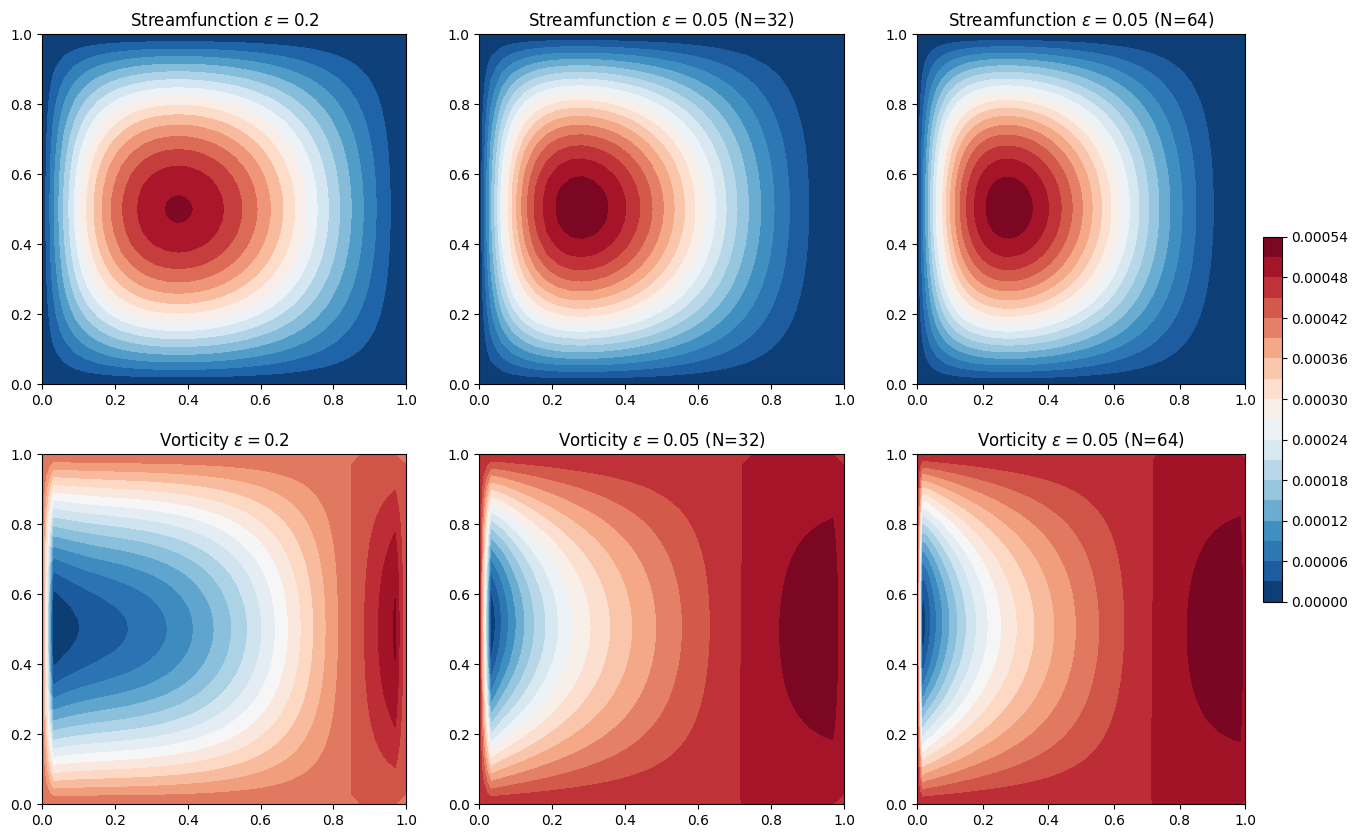

Computed max(psi)/R: 0.5295
Theoretical Estimate (2/pi): 0.6366


In [27]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt

def run_stommel_simulation(Nx, Ny, epsilon, R, label):
    '''
    Solves the steady-state Stommel problem for given parameters.
    '''
    # Grid setup
    x = np.linspace(0, 1, Nx + 1)
    y = np.linspace(0, 1, Ny + 1)
    dx = 1.0 / Nx
    dy = 1.0 / Ny
    X, Y = np.meshgrid(x, y)

    # Forcing: tau = -sin(pi*x)sin(pi*y) (One-signed, negative)
    tau = -np.sin(np.pi * X) * np.sin(np.pi * Y)

    # Precompute Poisson Solver (A * psi = zeta)
    N_int_x, N_int_y = Nx - 1, Ny - 1
    N_dof = N_int_x * N_int_y

    # Laplacian stencil
    main_diag = -2 * (1/dx**2 + 1/dy**2) * np.ones(N_dof)
    off_diag_x = (1/dx**2) * np.ones(N_dof - 1)
    off_diag_y = (1/dy**2) * np.ones(N_dof - N_int_x)

    # Handle boundaries in flattened array
    for k in range(1, N_dof):
        if k % N_int_x == 0: off_diag_x[k-1] = 0

    A = sp.diags([main_diag, off_diag_x, off_diag_x, off_diag_y, off_diag_y],
                 [0, 1, -1, N_int_x, -N_int_x], shape=(N_dof, N_dof), format='csc')
    solve_poisson = spla.factorized(A)

    # Initialisation
    psi = np.zeros((Ny + 1, Nx + 1))
    zeta = np.zeros((Ny + 1, Nx + 1))

    # Time stepping parameters
    dt = min(0.001, 0.5 * dx) # Adaptive step based on resolution
    tolerance = 1e-6
    max_steps = 20000

    for step in range(max_steps):
        # Calculate v (Central Difference)
        v = (psi[1:-1, 2:] - psi[1:-1, :-2]) / (2 * dx)

        # Update Jacobian (Arakawa)
        # For linear regime small R, J is negligible. We use a simple approx here
        # to focus on the beta/friction balance, or standard centered difference.
        # J(psi, zeta) = psi_x zeta_y - psi_y zeta_x
        p_x = (psi[1:-1, 2:] - psi[1:-1, :-2]) / (2*dx)
        p_y = (psi[2:, 1:-1] - psi[:-2, 1:-1]) / (2*dy)
        z_x = (zeta[1:-1, 2:] - zeta[1:-1, :-2]) / (2*dx)
        z_y = (zeta[2:, 1:-1] - zeta[:-2, 1:-1]) / (2*dy)
        J = p_x * z_y - p_y * z_x

        # Update Zeta (Semi-implicit friction)
        # Eq: zeta_new + eps*dt*zeta_new = zeta_old - dt*(J + v - R*tau)
        # Approximation: zeta_new = (zeta_old - dt*(J + v - R*tau)) / (1 + eps*dt)
        # Backward Euler is more stable and sufficient for steady state.

        rhs = zeta[1:-1, 1:-1] - dt * (J + v - R * tau[1:-1, 1:-1])
        zeta_new_int = rhs / (1 + epsilon * dt)

        diff = np.linalg.norm(zeta_new_int - zeta[1:-1, 1:-1])
        zeta[1:-1, 1:-1] = zeta_new_int

        # Update Psi
        psi[1:-1, 1:-1] = solve_poisson(zeta[1:-1, 1:-1].flatten()).reshape(N_int_y, N_int_x)

        if diff < tolerance:
            break

    return X, Y, psi, zeta

R_val = 0.001  # Small R for linear regime

X1, Y1, psi1, zeta1 = run_stommel_simulation(32, 32, 0.2, R_val, "Large Friction")
X2, Y2, psi2, zeta2 = run_stommel_simulation(32, 32, 0.05, R_val, "Small Friction")
X3, Y3, psi3, zeta3 = run_stommel_simulation(64, 64, 0.05, R_val, "High Res")

fig, axes = plt.subplots(2, 3, figsize=(16, 10))

axes[0,0].contourf(X1, Y1, psi1, 20, cmap='RdBu_r')
axes[0,0].set_title(r'Streamfunction $\epsilon=0.2$')
axes[1,0].contourf(X1, Y1, zeta1, 20, cmap='RdBu_r')
axes[1,0].set_title(r'Vorticity $\epsilon=0.2$')

axes[0,1].contourf(X2, Y2, psi2, 20, cmap='RdBu_r')
axes[0,1].set_title(r'Streamfunction $\epsilon=0.05$ (N=32)')
axes[1,1].contourf(X2, Y2, zeta2, 20, cmap='RdBu_r')
axes[1,1].set_title(r'Vorticity $\epsilon=0.05$ (N=32)')

c = axes[0,2].contourf(X3, Y3, psi3, 20, cmap='RdBu_r')
axes[0,2].set_title(r'Streamfunction $\epsilon=0.05$ (N=64)')
axes[1,2].contourf(X3, Y3, zeta3, 20, cmap='RdBu_r')
axes[1,2].set_title(r'Vorticity $\epsilon=0.05$ (N=64)')

plt.colorbar(c, ax=axes[:, 2], fraction=0.05)
plt.show()

# Run for epsilon = 0.05 with adequate resolution
X3, Y3, psi4, zeta4 = run_stommel_simulation(256, 32, 0.05, R_val, "High Res")
psi_max_scaled = np.max(psi4) / R_val
print(f"Computed max(psi)/R: {psi_max_scaled:.4f}")
print(f"Theoretical Estimate (2/pi): {2/np.pi:.4f}")

The asymmetry is caused by the $\beta$-effect term, represented in the dimensionless equation as $v$. This term represents the advection of planetary vorticity. It breaks the symmetry of the Poisson equation because it acts as a one-way wave propagation term where the Rossby waves propagate westward.

*   Case $\epsilon = 0.2$ (large friction): The flow is a broad, basin-wide gyre. While the center of the gyre is shifted slightly to the west, the streamlines are relatively symmetric and spaced out. The vorticity field roughly mirrors the wind forcing.
*   Case $\epsilon = 0.05$ (small friction): The solution becomes highly asymmetric. The gyre is pushed against the western wall $x=0$. The flow is broad and slow, moving southward. There is a very narrow, intense return current flowing northward along $x=0$. The streamlines here are packed very tightly, indicating high velocity.

In the interior flow, the dominant balance is the Sverdrup balance. Friction and nonlinear terms are negligible, as $v \approx R\tau$. The wind stress curl drives the meridional flow directly. In constract, for the western boundary layer, the dominant balance is the Stommel balance. The planetary vorticity advection is balanced by the frictional damping $v \approx -\epsilon \zeta$.

A strong current cannot exist near $x=1$. In the boundary layer, the balance is roughly $\epsilon \psi_{xx} + \psi_x \approx 0$. The characteristic equation is $\epsilon r^2 + r = 0$, which gives roots $r=0$ and $r = -1/\epsilon$. The non-zero root is negative, which corresponds to an exponentially decaying solution of the form $e^{-x/\epsilon}$. A layer at the eastern boundary would require a positive root $e^{+x/\epsilon}$ to decay westward.

Physically, the wind drives fluid southward $v < 0$, moving it to regions of lower planetary vorticity. To conserve mass, there must be a northward return flow $v>0$ which increases the planetary vorticity of the fluid parcels. To maintain a steady state, this gain must be offset by a loss of relative vorticity through friction. This requires the shear of a western boundary current to generate a frictional torque to close the vorticity budget.

---

In the linear limit $R \to 0$, the interior solution is governed by $\hat{v} = \tau$. Using $\tau = -\sin(\pi x)\sin(\pi y)$ and integrating from the eastern boundary $x=1$ where $\psi=0$, we obtain
\begin{align}
    \frac{\partial \hat{\psi}}{\partial x} &= -\sin(\pi x)\sin(\pi y), \\
    \hat{\psi}_{int}(x,y) &= \int_1^x -\sin(\pi x')\sin(\pi y) \, dx', \\
    &= \frac{1}{\pi}\sin(\pi y) [\cos(\pi x) + 1].
\end{align}
The maximum streamfunction typically occurs at the transition between the interior and the western boundary layer at $x=0$. Evaluating this at $x=0, y=1/2$ yields
\begin{equation}
    \hat{\psi}_{\max} \approx \frac{1}{\pi}(1)[1+1] = \frac{2}{\pi}.
\end{equation}

To adequately resolve the boundary current, the grid spacing must be significantly smaller than the boundary layer width $\delta_x \ll \epsilon$. A common rule of thumb is to have at least 5-10 grid points within the layer. For $\epsilon=0.05$, this implies $\delta_x \approx 0.005$, which would require $N_x \approx 200$.


---

Now, for fixed $\epsilon = 0.05$ we now investigate the steady-state behaviour as $R$ increases through the range $5 \times 10^{-4}$ to $10^{-1}$. The timestep $\Delta t$ must be reduced as $R$ increases, firstly to suppress numerical instability and secondly to allow a steady state to be achieved.

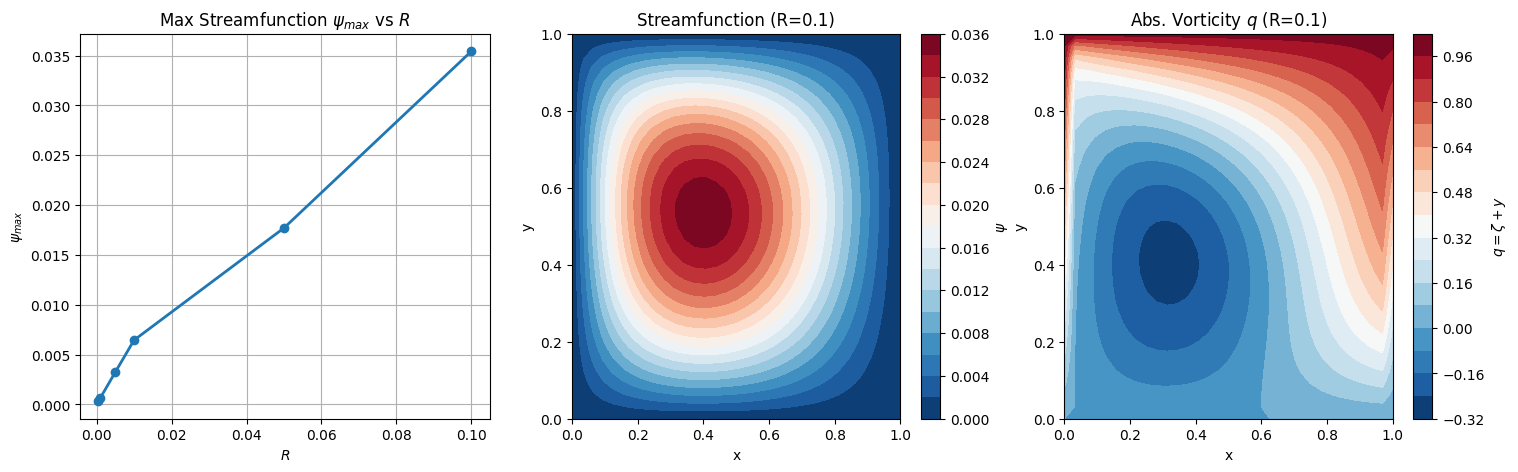

In [30]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt

def solve_stommel_nonlinear(Nx, Ny, epsilon, R_list):
    # Grid setup
    x = np.linspace(0, 1, Nx + 1)
    y = np.linspace(0, 1, Ny + 1)
    dx = 1.0 / Nx
    dy = 1.0 / Ny
    X, Y = np.meshgrid(x, y)

    # Forcing: tau = -sin(pi*x)sin(pi*y)
    tau = -np.sin(np.pi * X) * np.sin(np.pi * Y)

    # Precompute Poisson Solver (Matrix A)
    N_int_x, N_int_y = Nx - 1, Ny - 1
    N_dof = N_int_x * N_int_y

    main_diag = -2 * (1/dx**2 + 1/dy**2) * np.ones(N_dof)
    off_diag_x = (1/dx**2) * np.ones(N_dof - 1)
    off_diag_y = (1/dy**2) * np.ones(N_dof - N_int_x)

    # Fix boundary jumps in flattened array
    for k in range(1, N_dof):
        if k % N_int_x == 0: off_diag_x[k-1] = 0

    A = sp.diags([main_diag, off_diag_x, off_diag_x, off_diag_y, off_diag_y],
                 [0, 1, -1, N_int_x, -N_int_x], shape=(N_dof, N_dof), format='csc')
    solve_poisson = spla.factorized(A)

    psi_max_values = []

    # Storage for the final fields of the largest R run
    final_fields = {}

    for R in R_list:
        # Reset fields for each R (cold start is safer for stability comparison)
        psi = np.zeros((Ny + 1, Nx + 1))
        zeta = np.zeros((Ny + 1, Nx + 1))

        # Adjust dt based on R to maintain stability
        # Higher R -> Higher Velocity -> Needs smaller dt
        # Heuristic scaling:
        if R < 0.01:
            dt = 0.001
            max_steps = 20000
        elif R < 0.05:
            dt = 0.0005
            max_steps = 40000
        else:
            dt = 0.0001
            max_steps = 80000 # Needs long time to settle

        for step in range(max_steps):
            # Calculate v
            v = (psi[1:-1, 2:] - psi[1:-1, :-2]) / (2 * dx)

            # Jacobian J(psi, zeta) - Arakawa approximation
            # Slices for neighbors
            p_tr, p_tl = psi[2:, 2:], psi[2:, :-2]
            p_br, p_bl = psi[:-2, 2:], psi[:-2, :-2]
            z_t, z_b = zeta[2:, 1:-1], zeta[:-2, 1:-1]
            z_r, z_l = zeta[1:-1, 2:], zeta[1:-1, :-2]

            term1 = (p_tr - p_tl) * z_t
            term2 = (p_br - p_bl) * z_b
            term3 = (p_tr - p_br) * z_r
            term4 = (p_tl - p_bl) * z_l
            J = (term1 - term2 - term3 + term4) / (4 * dx * dy)

            # Time Step (semi-implicit friction)
            rhs = zeta[1:-1, 1:-1] - dt * (J + v - R * tau[1:-1, 1:-1])
            zeta_new = rhs / (1 + epsilon * dt / 2) # Using Crank-Nicolson factor approx

            # Simple convergence check (every 1000 steps)
            if step % 1000 == 0:
                diff = np.max(np.abs(zeta_new - zeta[1:-1, 1:-1]))
                if diff < 1e-8:
                    print(f"    Converged at step {step}")
                    zeta[1:-1, 1:-1] = zeta_new
                    break

            zeta[1:-1, 1:-1] = zeta_new

            # Solve Poisson
            psi[1:-1, 1:-1] = solve_poisson(zeta[1:-1, 1:-1].flatten()).reshape(N_int_y, N_int_x)

        psi_max = np.max(psi)
        psi_max_values.append(psi_max)

        # Save the fields for the largest R
        if R == R_list[-1]:
            final_fields['psi'] = psi
            final_fields['zeta'] = zeta
            final_fields['q'] = zeta + Y  # Absolute vorticity
            final_fields['R'] = R

    return R_list, psi_max_values, X, Y, final_fields

R_values = [0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]
R_out, psi_max_out, X, Y, data = solve_stommel_nonlinear(32, 32, 0.05, R_values)

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(R_out, psi_max_out, 'o-')
plt.title(r'Max Streamfunction $\psi_{max}$ vs $R$')
plt.xlabel('$R$')
plt.ylabel(r'$\psi_{max}$')
plt.grid(True)

plt.subplot(1, 3, 2)
plt.contourf(X, Y, data['psi'], 20, cmap='RdBu_r')
plt.colorbar(label=r'$\psi$')
plt.title(f'Streamfunction (R={data["R"]})')
plt.xlabel('x')
plt.ylabel('y')

plt.subplot(1, 3, 3)
plt.contourf(X, Y, data['q'], 20, cmap='RdBu_r')
plt.colorbar(label=r'$q = \zeta + y$')
plt.title(f'Abs. Vorticity $q$ (R={data["R"]})')
plt.xlabel('x')
plt.ylabel('y')

plt.show()

As $R$ increases, the forcing strength increases relative to friction. For low $R$, the flow is in the linear Stommel regime. We see a Sverdrup interior and a simple, monotonic western boundary current. When $R$ is high, the non-linear advection term $u \cdot \nabla \zeta$ becomes significant. The western boundary current becomes so strong that it overshoots the northwest corner. We observe the streamlines in the northwest corner tightening.

In highly non-linear regimes, an inertial recirculation gyre can form where fluid spins rapidly in a sub-loop before rejoining the main Sverdrup interior. The north-south symmetry of the vorticity field (present in the pure linear friction case) breaks down further as advection transports vorticity downstream.

In the region of strong flow (the western boundary and the returning jet), the contours of $\psi$ and $q$ tend to align. When contours of a scalar $q$ are parallel to streamlines $\psi$, it means that $u \cdot \nabla q \approx 0$. This indicates that the inertial terms are dominant. The balance is the conservation of absolute vorticity following the flow
\begin{equation}
    u \cdot \nabla(\zeta + y) \approx 0.
\end{equation}
Friction and wind forcing become secondary in the fast inertial core, acting only to set the bulk potential vorticity over longer time or spatial scales.

---

The plot of $\psi_{\text{max}}$ against $R$ is approximately linear. Despite the local non-linearities in the boundary layer due to inertial recirculation, the total transport of the gyre is largely due to Sverdrup relation in the interior. Here, the non-linear terms and friction are small. The balance is $v \approx R \tau$ where integrating $v = \partial \psi / \partial x$ gives $\psi \propto R$. Thus, the boundary current acts to close the mass budget defined by the interior, therefore, the maximum transport scales linearly with the wind forcing strength $R$.

1.  Small $R$ limit (linear Stommel): Here, $\psi_{\text{max}}$ is independent of $\epsilon$. The maximum transport is determined by the Sverdrup interior integration $\int \nabla \times \tau \,dx$. Friction $\epsilon$ determines the width of the boundary layer, but not the total mass transport carried by it.

2.  Large $R$ limit (inertial): If $R$ becomes very large, inertial recirculation gyres grow. In these modes where $q$ is constant, the transport can become dependent on friction again. Lower friction $\epsilon \to 0$ allows the inertial gyres to spin up to very high velocities without dissipating energy. Therefore, we might expect $\psi_{\text{max}}$ to increase as $\epsilon$ decreases, where the gyre spins faster than the Sverdrup prediction.